# Square Gradient Theory for Mixtures

Square Gradient Theory allows studying the interfacial behavior of fluid. SGT proposes that the Helmholtz free energy density at the interface can be described by the sum of a homogeneous and a gradient contribution, in which the density profiles between the bulk phases are mean to minimize the energy of the system. This results in the following Euler-Lagrange system: 

$$ \sum_j c_{ij} \frac{d^2 \rho_j}{dz^2} = \mu_i - \mu_i^0 \qquad i = 1,...,c$$ 
$$ \rho(z \rightarrow -\infty) = \rho^\alpha \qquad \rho(z \rightarrow \infty) = \rho^\beta $$

Here, $z$ represents the interfacial position,  $\mu$, the chemical potential and $\rho$ the density vector. The superscript 0 refers to the bulk phase value and $\alpha$, $\beta$ to the bulk phases index. Finally, $c_{ij}$, represents the cross-influence parameter between molecule $i$ and $j$ and, in general, is computed as the geometric mean of the pure fluid's influence parameter and a correction factor:

$$ c_{ij} = (1 - \beta_{ij}) \sqrt{c_{ii} c_{jj}} $$

The solution procedure of the SGT strongly depends on whether the influence parameter matrix is singular or not. If all $\beta_{ij} = 0$, the matrix is singular and the differential equation reduces to the following algebraic system of equations.

$$ \sqrt{c_{rr}} \left[ \mu_i - \mu_i^0 \right] = \sqrt{c_{ii}} \left[ \mu_r - \mu_r^0 \right] \qquad  i = 1,...,c, i \neq r $$

Here $r$ refers to the reference component index.

Once the density profiles are solved the interfacial tension can be computed as:

$$ \sigma =  \int_{-\infty}^{\infty} \sum_i \sum_j c_{ij} \frac{d\rho_i}{dz} \frac{d\rho_j}{dz} dz $$

This notebook has the purpose of showing examples of computing interfacial tension of mixtures and $\beta_{ij} = 0$.

First, it's needed to import the necessary modules

In [1]:
import numpy as np
from phasepy import component, mixture, prsveos
from phasepy.equilibrium import bubblePy
from phasepy.sgt import sgt_mix_beta0
import matplotlib.pyplot as plt

Then a mixture and the EoS are created.

In [2]:
#component creation
water =  component(name = 'Water', Tc = 647.13, Pc = 220.55, Zc = 0.229, Vc = 55.948, w = 0.344861,
                ksv = [ 0.87185176, -0.06621339],
                cii = [2.06553362e-26, 2.64204784e-23, 4.10320513e-21],
                GC = {'H2O':1})

ethanol = component(name = 'Ethanol', Tc = 514.0, Pc = 61.37, Zc = 0.241, Vc = 168.0, w = 0.643558,
                ksv = [1.27092923, 0.0440421 ],
                cii = [ 2.35206942e-24, -1.32498074e-21,  2.31193555e-19],
                GC = {'CH3':1, 'CH2':1, 'OH(P)':1})

mix = mixture(ethanol, water)
# or
mix = ethanol + water
mix.unifac()
eos1 = prsveos(mix, 'mhv_unifac')

With the ``eos`` object the equilibrium point is computed with the ``bubblePy`` function.  For this example, the bubble point of a mixture of x1 = 0.3 at 320K is computed.

In [3]:
T = 320. #K
X = np.array([0.3, 0.7])
P0 = 0.3 #bar
Y0 = np.array([0.7, 0.3])

#The full_output option allows to obtain the compositions and volume of the phases
sol = bubblePy(Y0, P0, X, T, eos1, full_output = True)
Y = sol.Y
P = sol.P
vl = sol.v1
vv = sol.v2

#computing the density vector
rhol = X / vl
rhov = Y / vv

If the ```full_output``` is set to false, the densities vector of the phases can be computed as follows:

In [4]:
rhol = eos1.density(X, T, P, 'L') * X
rhov = eos1.density(Y, T, P, 'V') * Y 

With the computed equilibrium values (rhov, rhol, T, P) SGT can be used to study the interfacial behavior of the mixture. 

To solve the density profiles there are two available method:
- ``reference``: used the reference component method. The parameter ``s`` sets the index for the reference component.
- ``cornelisse``: uses Cornlisse's path function:

$$ (dh)^2 = \sum_i  c_{ii} d\rho_i^2$$

- ``liang``: uses [Liang's path function](https://www.sciencedirect.com/science/article/pii/S0378381216300450):

$$ h = \sum_i \sqrt{c_{ii}} \rho_i $$

This path function (``h``) is coupled to the algebraic system and allows solving the density profile even when there are multiple stationary points in the interface. Additionally, Liang's path function defines a parametric variable $\alpha$ which is zero at the equilibrium conditions. The values of $\alpha$ can be used to check if the geometric mixing rule for the influence parameter is suitable for the mixture.

In [5]:
#if reference component is set to ethanol (index = 0) a lower value is obtained as the 
#full density profile was not calculated because of a stationary point in the interface
solr1 = sgt_mix_beta0(rhov, rhol, T, P, eos1, s = 0, n = 100, method = 'reference', full_output = True)

#water doesnt show surface activity across the interface and the density profiles are fully calculated
solr2 = sgt_mix_beta0(rhov, rhol, T, P, eos1, s = 1, n = 100, method = 'reference', full_output = True)

#Using Liang path function the density profiles are computed directly
soll = sgt_mix_beta0(rhov, rhol, T, P, eos1, n= 500, method = 'liang', full_output = True)

#Cornelisse path function also allows to compute the density profiles
solc = sgt_mix_beta0(rhov, rhol, T, P, eos1, n = 500, method = 'cornelisse', full_output = True)

/opt/homebrew/Caskroom/miniforge/base/envs/thermo/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [6]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function (1) : ', soll.tension, 'mN/m')
print('Cornelisse path Function (1) : ', solc.tension, 'mN/m')

Reference component method (1) :  15.816492169904361 mN/m
Reference component method (2) :  27.285131501644393 mN/m
Liang path Function (1) :  27.284533691245375 mN/m
Cornelisse path Function (1) :  27.284274705236363 mN/m


The ```full_output``` options allows to obtain tension value, density profiles and grand thermodynamic potential.
Those values are accessed similar as SciPy OptimizeResult.

1. sol.tension -> calculated IFT
2. sol.rho -> density array
3. sol.z -> interfacial lenght array
4. sol.GPT -> grand thermodynamic potential


The results can be plotted an compared. As can be seen, when ethanol is used as a reference component this method is not able to compute the density profile from one bulk phase to another.
When studying the alpha variable from Liang path function it can be seen that its value at the edge is zero as well as somehwehre in the middle. This is expected when the geometric mean rule for the influence parameter with no correction can be used for the mixture.

Text(0.5, 0, 'path function')

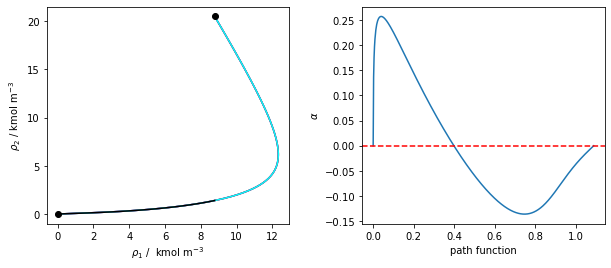

In [7]:
%matplotlib inline

rhor1 = 1000 * solr1.rho #kmol/m3
rhor2 = 1000 * solr2.rho #kmol/m3

rholiang = 1000 * soll.rho #kmol/m3
alphas = soll.alphas
path = soll.path

rhoc = 1000* solc.rho


fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rhoc[0], rhoc[1], color = 'blue')
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(rhor1[0], rhor1[1], color = 'black')
ax1.plot(1000* rhov[0], 1000*rhov[1], 'o', color = 'k')
ax1.plot(1000*rhol[0], 1000*rhol[1], 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ /  kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function')

A more challenging mixture to analyze is ethanol and hexane. This mixture has several stationary points across the interface making its calculations tricky. Similar as before, equilibrium has to be computed. 

In [8]:
hexane = component(name = 'n-Hexane', Tc = 507.6, Pc = 30.25, Zc = 0.266, Vc = 371.0, w = 0.301261, 
                ksv = [ 0.81185833, -0.08790848],
                cii = [ 5.03377433e-24, -3.41297789e-21,  9.97008208e-19],
                GC = {'CH3':2, 'CH2':4})

mix = mixture(ethanol, hexane)
# or
mix = ethanol + hexane

a12, a21 = np.array([1141.56994427,  125.25729314])
A = np.array([[0, a12], [a21, 0]])
mix.wilson(A)

eos2 = prsveos(mix, 'mhv_wilson')

T = 320 #K
X = np.array([0.3, 0.7])
P0 = 0.3 #bar
Y0 = np.array([0.7, 0.3])

sol = bubblePy(Y0, P0, X, T, eos2, full_output = True)
Y = sol.Y
P = sol.P
vl = sol.v1
vv = sol.v2

#computing the density vector
rhol = X / vl
rhov = Y / vv

Then SGT is used with the different methods available for beta = 0

In [9]:
solr1 = sgt_mix_beta0(rhov, rhol, T, P, eos2, s = 0, n = 100, method = 'reference', full_output = True)
solr2 = sgt_mix_beta0(rhov, rhol, T, P, eos2, s = 1, n = 100, method = 'reference', full_output = True)

soll = sgt_mix_beta0(rhov, rhol, T, P, eos2, n= 500, method = 'liang', full_output = True)

solc = sgt_mix_beta0(rhov, rhol, T, P, eos2, n= 500, method = 'cornelisse', full_output = True)

/opt/homebrew/Caskroom/miniforge/base/envs/thermo/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/gac21/Documents/phasepy/phasepy/cubic/cubicmix.py:586: RuntimeWarning: invalid value encountered in log
  g = np.log(V_B/V)
/Users/gac21/Documents/phasepy/phasepy/cubic/cubicmix.py:587: RuntimeWarning: invalid value encountered in log
  f = np.log(Vc1B / Vc2B) / (R * B * (c1 - c2))


In [10]:
print('Reference component method (1) : ', solr1.tension, 'mN/m')
print('Reference component method (2) : ', solr2.tension, 'mN/m')
print('Liang path Function (1) : ', soll.tension, 'mN/m')
print('Cornelisse path Function (1) : ', solc.tension, 'mN/m')

Reference component method (1) :  12.920799769272916 mN/m
Reference component method (2) :  15.586991657947161 mN/m
Liang path Function (1) :  14.390273869229079 mN/m
Cornelisse path Function (1) :  15.645030807866522 mN/m


Finally, the density profiles can be plotted. As can be seen, only Cornelisse path function is able to compute the density profiles from one bluk phase to another correctly. Reference method and Liang path function stop a one of the stationary points. 

When studying the alpha variable from Liang path function it can be seen that the end value is not zero. This variable should take the value of zero at three values: at the edges and somewehre in the middle. This is a clear sign that the geometric mean rule for the influence parameter is not suitable for this mixture. 

Text(0.5, 0, 'path function')

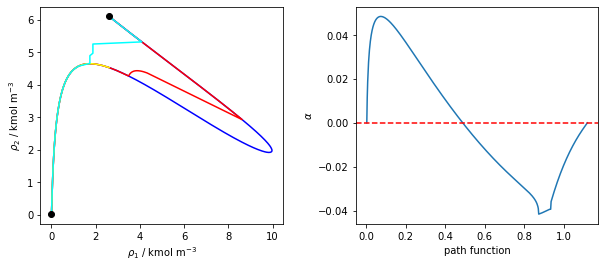

In [11]:
%matplotlib inline

rhor1 = 1000 * solr1.rho #kmol/m3
rhor2 = 1000 * solr2.rho #kmol/m3

rholiang = 1000 * soll.rho #kmol/m3
alphas = soll.alphas
path = soll.path

rhoc = 1000* solc.rho

fig = plt.figure(figsize = (10, 4))
fig.subplots_adjust( wspace=0.3)
ax1 = fig.add_subplot(121)
ax1.plot(rhoc[0], rhoc[1], color = 'blue')
ax1.plot(rholiang[0], rholiang[1], color = 'red')
ax1.plot(rhor1[0], rhor1[1], color = 'yellow')
ax1.plot(rhor2[0], rhor2[1], color = 'cyan')
ax1.plot(1000 * rhov[0], 1000*rhov[1], 'o', color = 'k')
ax1.plot(1000 * rhol[0], 1000*rhol[1], 'o', color = 'k')
ax1.set_xlabel(r'$\rho_1$ / kmol m$^{-3}$')
ax1.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$')

ax2 = fig.add_subplot(122)
ax2.plot(path, alphas)
ax2.axhline(y = 0, linestyle = '--',color = 'r')
ax2.set_ylabel(r'$\alpha$')
ax2.set_xlabel(r'path function')

For further information please also check [official documentation](https://phasepy.readthedocs.io/), or just try:

```function?```